# Projekt

### Konfiguracja

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 1.4


added_points = []
added_lines = []

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
#             self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
                added_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                added_points.append(new_point)
                added_lines.append([self.rect_points[-1], new_point])
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                    added_lines.append([self.rect_points[-1], self.rect_points[0]])
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                    added_lines.append([self.rect_points[-1], new_point])
                    added_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [68]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Zamknij punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Rozwiązanie

<IPython.core.display.Javascript object>


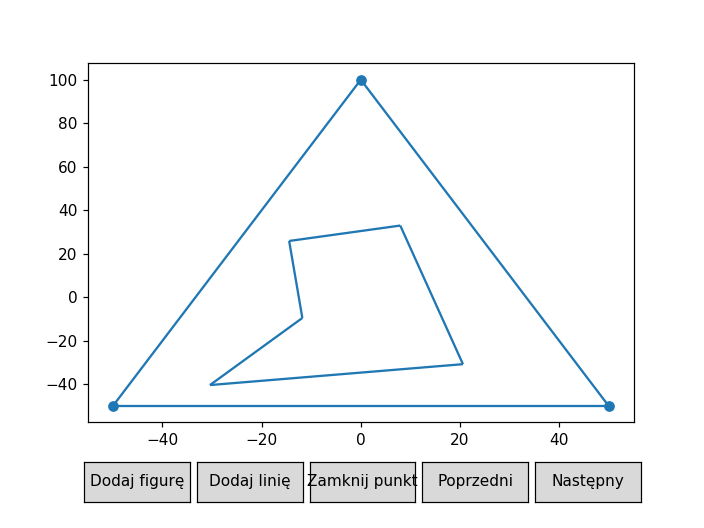

In [91]:
%matplotlib notebook


added_points = []
class Triangle():
    def __init__(self, lines=None, points=None):
        self.points = [point for point in points]
        self.lines = []
            
        for i,point in enumerate(self.points[:-1]):
            self.lines.append( [point, self.points[i+1]] )
        self.lines.append( [self.points[-1], self.points[0]] )
            
        
        
        
outerTriangle = Triangle(points=((-50,-50),(50,-50),(0,100)))
added_points.append((-50,-50))
added_points.append((50,-50))
added_points.append((0,100))

scenes=[Scene([PointsCollection(outerTriangle.points)], [LinesCollection(outerTriangle.lines)])]



plot = Plot(scenes)
plot.draw() 



In [72]:
print(len(added_points))
print(added_points)


8
[(-50, -50), (50, -50), (0, 100), (-21.53549288969011, -28.644843078402076), (23.046512345741718, -26.1169597973323), (9.738451081433709, 33.541085635914555), (-11.776247962530903, 34.0466622921285), (-21.09189084754651, 12.81244273114234)]


In [67]:
!{sys.executable} -m pip install --user numpy scipy matplotlib ipython jupyter pandas sympy nose


    100% |████████████████████████████████| 163kB 7.3MB/s ta 0:00:01
    100% |████████████████████████████████| 122kB 21.2MB/s ta 0:00:01


<IPython.core.display.Javascript object>


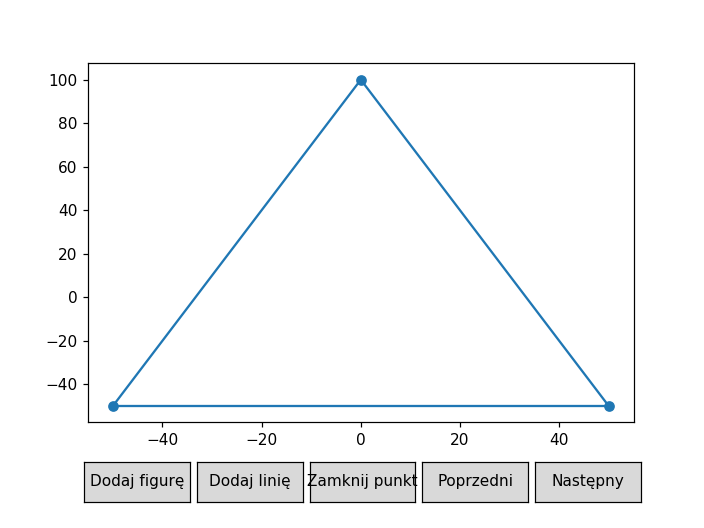

In [92]:

class Graph:
    def __init__(self, lines, points, faces):
        self.lines = lines
        self.points = points
        self.pointsLen = len(points)
        self.activePoints = np.ones(self.pointsLen, dtype = bool)
        # really collection of triangles         
        self.faces = faces
        self.edgeToFace = np.empty((self.pointsLen, self.pointsLen), dtype=object)      

        for face in self.faces:
            self.addToEdgeToFace(face)
            
            
    def updateFaces(self, faces):
        for face in self.faces:
            self.addToEdgeToFace(face)
        
    def addToEdgeToFace(self, face):
        p1 = self.findIndex(face.points[0])
        p2 = self.findIndex(face.points[1])
        p3 = self.findIndex(face.points[2])

        self._addFaceToEdge(p1, p2, face)
        self._addFaceToEdge(p1, p3, face)
        self._addFaceToEdge(p2, p3, face)
    
    def findIndex(self, v):
        for i,p in enumerate(self.points):
            if p[0] == v[0] and p[1] == v[1]:
                return i
        
    def _addFaceToEdge(self, a, b, face):
        # one way edge
        if self.edgeToFace[a][b] is None:
            self.edgeToFace[a][b] = face

        # add for other way
        if self.edgeToFace[b][a] is None:
            self.edgeToFace[b][a] = face

            
    def degree(self, vertexIndex):
        assert(vertexIndex >= 3)
        c = 0
        for i in range(0, self.pointsLen):
            if self.edgeToFace[vertexIndex][i] is not None:
                c +=1
        return c
    
    def findIndependentSetWithDegreeLessThen8(self):
        
        startingPoint = self.points[0]
        
        marked = np.zeros(self.pointsLen, dtype = bool)
        # first three are from outer triangle
        for i in range(0, 3):
            marked[i] = True
        for i,activePoint in enumerate(self.activePoints):
            if not activePoint:
                marked[i] = True
            
        for i in range(3, self.pointsLen):
            if self.degree(i) > 8:
                marked[i] = True 
        
        independentSet = []
        for i in range(3, self.pointsLen):
            if not marked[i]:
                independentSet.append(i)
                marked[i] = True
                for j in range(len(self.edgeToFace)):
                    if j == i:
                        for k in range(len(self.edgeToFace[j])):
                            if self.edgeToFace[j][k] is not None:
                                marked[k] = True
    
        return independentSet
    
    def deactivatePoints(self,pointsToDeactivateIndecies):
        for index in pointsToDeactivateIndecies:
            self.activePoints[index] = False
        
    def getAllActivePoints(self):
        active = []
        for i,p in enumerate(self.points):
            if self.activePoints[i]:
                active.append(p)
        return active
                    
    def getAllActiveLines(self):
        active = []
        for i,p in enumerate(self.lines):
            if self.isLineActive(p):
                active.append(p)   
        return active

    def isLineActive(self, line):
        i = self.getPointIndex(line[0])
        j = self.getPointIndex(line[1])
        return (self.edgeToFace[i][j] is not None) and self.activePoints[i] and self.activePoints[j] 
    
    def getPointIndex(self,point):
        for i,p in enumerate(self.points):
            if p[0] == point[0] and p[1] == point[1]:
                return i
                    
                    
                     
scenes=[]


triangulation = sp.Delaunay(added_points)

faces = []
for i in triangulation.simplices:
    faces.append(Triangle(points=(added_points[i[0]],added_points[i[1]],added_points[i[2]])))
               
all_lines = []
for triangle in faces:
    for lines in triangle.lines:
        all_lines.append(lines)


scenes.append(Scene([PointsCollection(added_points)], [LinesCollection(all_lines)]))

graph = Graph(lines=all_lines, points=added_points,faces=faces)

p1 = graph.getAllActivePoints()

while len(p1) > 3:
    set = graph.findIndependentSetWithDegreeLessThen8()
    setPoints = []
    for index in set:
        setPoints.append(graph.points[index])
    
    graph.deactivatePoints(set)

    p1 = graph.getAllActivePoints()
    l1 = graph.getAllActiveLines()

    scenes.append(Scene([PointsCollection(p1), PointsCollection(setPoints, color='red')], [LinesCollection(l1)]))

    triangulation = sp.Delaunay(p1)
    

    faces = []
    for i in triangulation.simplices:
        faces.append(Triangle(points=(p1[i[0]],p1[i[1]],p1[i[2]])))

    all_lines = []
    for triangle in faces:
        for lines in triangle.lines:
            all_lines.append(lines)
            
    graph = Graph(lines=l1, points=p1,faces=faces)
    
    scenes.append(Scene([PointsCollection(p1)], [LinesCollection(all_lines)]))

plot = Plot(scenes)
plot.draw() 


    